In [1]:
# This file provide template to download the TinyImageNet dataset and then sample code to profile: single, online and batch inference

import tensorflow as tf
import pathlib
import numpy as np
import os
from datetime import datetime
from packaging import version
import matplotlib.pyplot as plt
from tensorflow.keras import Model

# Disable GPU!!!
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"



2021-10-11 16:10:06.068753: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
# Should print the tf version: 2.4.1.
print(tf.__version__)

2.4.1


In [3]:
# Installs the latest tensorboard plugin
!pip install -U tensorboard_plugin_profile

In [4]:
# Set host level to highest priority for profiling
tf.profiler.experimental.ProfilerOptions(
    host_tracer_level=1, python_tracer_level=0, device_tracer_level=1
)

ProfilerOptions(host_tracer_level=1, python_tracer_level=0, device_tracer_level=1, delay_ms=None)

In [5]:
# We have to load the tiny imagenet data as usual:

# Make sure that unzipped tiny-imagenet-200 folder is placed in the current directory
#define path to the dataset
path = pathlib.Path('/local/tiny-imagenet-200')

In [6]:
# Map the wnids to integer labels to words
with open(os.path.join(path, 'wnids.txt'), 'r') as f:
  wnids = [x.strip() for x in f]


# Map wnids to integer labels
wnid_to_label = {wnid: i for i, wnid in enumerate(wnids)}
label_to_wnid = {v: k for k, v in wnid_to_label.items()}

# Use words.txt to get names for each class
with open(os.path.join(path, 'words.txt'), 'r') as f:
  wnid_to_words = dict(line.split('\t') for line in f)
  for wnid, words in wnid_to_words.items():
      wnid_to_words[wnid] = [w.strip() for w in words.split(',')]
class_names = [wnid_to_words[wnid] for wnid in wnids]

In [7]:
# Import necessary packages
from __future__ import print_function
from builtins import range
from six.moves import cPickle as pickle
import numpy as np
import os
import platform
from tqdm import tqdm
import random
from imageio import imread
from imageio import imsave


# Function for loading the tiny imagenet data
def load_tiny_imagenet(path, is_training=True, dtype=np.float32, subtract_mean=True, debug=False, debug_nclass=3):
    """
    Load TinyImageNet. Each of TinyImageNet-100-A, TinyImageNet-100-B, and
    TinyImageNet-200 have the same directory structure, so this can be used
    to load any of them.

    Note: The original implementation loaded data as NCHW, I (tyler) changed it to NHWC

    Inputs:
    - path: String giving path to the directory to load.
    - is_training: If True, dont load testing data, if False, dont load training and val data
        Note: Must always load training data in order to subtract_mean.
    - dtype: numpy datatype used to load the data.
    - subtract_mean: Whether to subtract the mean training image.
    - debug: Whether or not to load a small number of classes for debugging

    Returns: A dictionary with the following entries:
    - class_names: A list where class_names[i] is a list of strings giving the
      WordNet names for class i in the loaded dataset.
    - X_train: (N_tr, 64, 64, 3) array of training images
    - y_train: (N_tr,) array of training labels
    - X_val: (N_val, 64, 64, 3) array of validation images
    - y_val: (N_val,) array of validation labels
    - X_test: (N_test, 64, 64, 3) array of testing images.
    - y_test: (N_test,) array of test labels; if test labels are not available
      (such as in student code) then y_test will be None.
    - mean_image: (64, 64, 3) array giving mean training image
    - label_to_wnid: dictionary with mapping from integer class label to wnid
    """
    # First load wnids
    with open(os.path.join(path, 'wnids.txt'), 'r') as f:
        wnids = [x.strip() for x in f]

    # Map wnids to integer labels
    wnid_to_label = {wnid: i for i, wnid in enumerate(wnids)}
    label_to_wnid = {v: k for k, v in wnid_to_label.items()}

    # Use words.txt to get names for each class
    with open(os.path.join(path, 'words.txt'), 'r') as f:
        wnid_to_words = dict(line.split('\t') for line in f)
        for wnid, words in wnid_to_words.items():
            wnid_to_words[wnid] = [w.strip() for w in words.split(',')]
    class_names = [wnid_to_words[wnid] for wnid in wnids]

    if debug:
        print('Debug is on! Only loading %d / %d training classes.'
                  % (debug_nclass, len(wnids)))

    # Next load training data.
    X_train, y_train = [], []
    train_wnids = wnids[:debug_nclass] if debug else wnids
    for i, wnid in tqdm(enumerate(train_wnids), total=len(train_wnids)):
        # To figure out the filenames we need to open the boxes file
        boxes_file = os.path.join(path, 'train', wnid, '%s_boxes.txt' % wnid)
        with open(boxes_file, 'r') as f:
            filenames = [x.split('\t')[0] for x in f]
        num_images = len(filenames)

        X_train_block = np.zeros((num_images, 64, 64, 3), dtype=dtype)
        y_train_block = wnid_to_label[wnid] * \
                        np.ones(num_images, dtype=np.int64)
        for j, img_file in enumerate(filenames):
            img_file = os.path.join(path, 'train', wnid, 'images', img_file)
            img = imread(img_file)
            if img.ndim == 2:   ## grayscale file
                img.shape = (64, 64, 1)
            X_train_block[j] = img
        X_train.append(X_train_block)
        y_train.append(y_train_block)

    # We need to concatenate all training data
    X_train = np.concatenate(X_train, axis=0)
    y_train = np.concatenate(y_train, axis=0)

    # Next load validation data
    X_val, y_val = None, None
    if is_training:
        print('loading validation data')
        with open(os.path.join(path, 'val', 'val_annotations.txt'), 'r') as f:
            img_files = []
            val_wnids = []
            for line in f:
                img_file, wnid = line.split('\t')[:2]
                img_files.append(img_file)
                val_wnids.append(wnid)
            num_val = len(img_files)
            y_val = np.array([wnid_to_label[wnid] for wnid in val_wnids])
            X_val = np.zeros((num_val, 64, 64, 3), dtype=dtype)
            for i, img_file in tqdm(enumerate(img_files), total=len(img_files)):
                img_file = os.path.join(path, 'val', 'images', img_file)
                img = imread(img_file)
                if img.ndim == 2:
                    img.shape = (64, 64, 1)
                X_val[i] = img

    mean_image = None
    if subtract_mean:
        mean_image = X_train.mean(axis=0)
        if is_training:
            X_train -= mean_image[None]
            X_val -= mean_image[None]
        else:
            X_test -= mean_image[None]

    if not is_training:
        X_train = None
        y_train = None

    return {
      'class_names': class_names,
      'X_train': X_train,
      'y_train': y_train,
      'X_val': X_val,
      'y_val': y_val,
      'mean_image': mean_image,
      'label_to_wnid': label_to_wnid
    }


In [8]:
print ("Loading Tiny-Imagenet Dataset for training and validation data")
dataset_train_val = load_tiny_imagenet(path, is_training = True, dtype=np.float32, subtract_mean=False)
x_val = dataset_train_val["X_val"] # 10000 images when each is a 64*64*3
y_val = dataset_train_val["y_val"] # 10000 elements


Loading Tiny-Imagenet Dataset for training and validation data


100%|█████████████████████████████████████████| 200/200 [00:45<00:00,  4.40it/s]


loading validation data


100%|███████████████████████████████████| 10000/10000 [00:05<00:00, 1672.08it/s]


In [9]:
# Normalize all the float data between 0 and 1
x_val = x_val/255.0

In [10]:
# one hot encode y data
from tensorflow.keras.utils import to_categorical
num_classes = 200
y_val = to_categorical(y_val, num_classes)

In [11]:
# To do:  Load the H5 model and print summary. 
# Please make sure the h5 model file is present in the /local/ directory
# Sample code to load the model
model = tf.keras.models.load_model('/local/CNN_TinyImageNet_2.h5')

2021-10-11 16:11:07.401549: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-11 16:11:07.407460: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-10-11 16:11:07.426616: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-10-11 16:11:07.426686: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: cpre482-14.ece.iastate.edu
2021-10-11 16:11:07.426699: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: cpre482-14.ece.iastate.edu
2021-10-11 16:11:07.426823: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.63.1
2021-10-11 16:11:07.426868: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.63.1
2021-10-11 16:11:07.42687

In [12]:
# Sample Profiling: Inference for a single image:

# chose any desired image between 0 and 9999 (10,000 validation set images)
image_index=0

# load the data
val_single_image = tf.data.Dataset.from_tensors(x_val[image_index].reshape(1,64,64,3)) 


logs="/local/Lab2/Tensorboard/Template_Profiling/logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")


# Perform the inference profiling:

# Starts Profile logging
tf.profiler.experimental.start(logs)

# Actual inference
model.predict(val_single_image, use_multiprocessing=True)

# Stops Profile logging
tf.profiler.experimental.stop()

# Load the TensorBoard notebook extension.
%load_ext tensorboard

# Launch TensorBoard and navigate to the Profile tab to view performance profile. 
# *** Please note just execute this command ones in a session and 
# then logs for subsequent runs would be auto detected in tensorboard- url: http://localhost:6006/
%tensorboard --logdir=logs

# You could view the tensorboard in the browser url: http://localhost:6006/

# Image 0: Layer 2 (conv2d_1) impacted computation time the most. This is probably because it is doing
# the most computations out of any of the layers (60 x 60 x 32 input with 5 x 5 x 32 filter)

#Image 1: Layer 2 impacted computation time the most for reasons similar to Image 0.

#Image 2: Layer 2 impacted computation time the msot for reasons similar to Image 0.

2021-10-11 16:11:07.604948: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-10-11 16:11:07.604978: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2021-10-11 16:11:07.698619: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-10-11 16:11:07.699536: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2294605000 Hz
2021-10-11 16:11:07.788684: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2021-10-11 16:11:07.790068: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2021-10-11 16:11:07.797612: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: /local/Lab2/Tensorboard/Template_Profiling/logs/20211011-161107/plugins/profile/2021_10_11_16_11_07
2021-10-11 16:11:07.798588: I tensorflow/core/profiler/rpc/client/s

Reusing TensorBoard on port 6006 (pid 6751), started 6 days, 23:42:45 ago. (Use '!kill 6751' to kill it.)

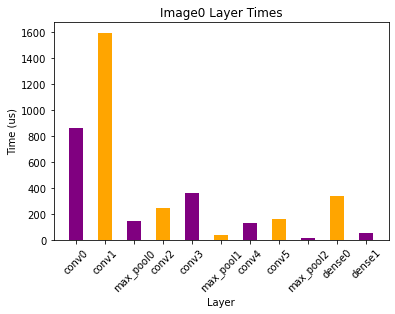

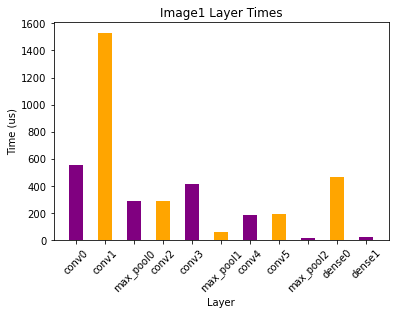

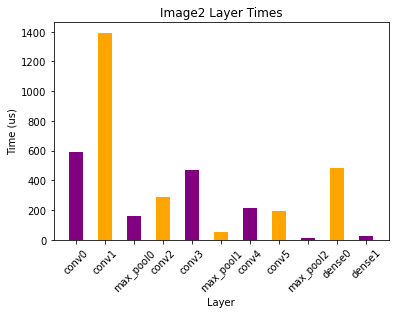

In [13]:
#Bar graphs
#Image 0
xaxis = [1,2,3,4,5,6,7,8,9,10,11]
yaxis = [863, 1594, 145, 247, 363, 39, 133, 162, 13, 341, 49]
tick_label = ['conv0', 'conv1', 'max_pool0', 'conv2', 'conv3', 'max_pool1', 'conv4', 'conv5', 'max_pool2', 'dense0', 'dense1']
plt.bar(xaxis,yaxis,tick_label = tick_label, width = .5, color = ['purple', 'orange'])
plt.xlabel('Layer')
plt.ylabel('Time (us)')
plt.title('Image0 Layer Times')
plt.xticks(rotation=45)
plt.show()

#Image 1
xaxis = [1,2,3,4,5,6,7,8,9,10,11]
yaxis = [554, 1531, 285, 286, 409, 59, 181, 189, 12, 462, 23]
tick_label = ['conv0', 'conv1', 'max_pool0', 'conv2', 'conv3', 'max_pool1', 'conv4', 'conv5', 'max_pool2', 'dense0', 'dense1']
plt.bar(xaxis,yaxis,tick_label = tick_label, width = .5, color = ['purple', 'orange'])
plt.xlabel('Layer')
plt.ylabel('Time (us)')
plt.title('Image1 Layer Times')
plt.xticks(rotation=45)
plt.show()

#Image 2
xaxis = [1,2,3,4,5,6,7,8,9,10,11]
yaxis = [592, 1393, 162, 288, 471, 54, 215, 196, 13, 481, 23]
tick_label = ['conv0', 'conv1', 'max_pool0', 'conv2', 'conv3', 'max_pool1', 'conv4', 'conv5', 'max_pool2', 'dense0', 'dense1']
plt.bar(xaxis,yaxis,tick_label = tick_label, width = .5, color = ['purple', 'orange'])
plt.xlabel('Layer')
plt.ylabel('Time (us)')
plt.title('Image2 Layer Times')
plt.xticks(rotation=45)
plt.show()

In [14]:
# Sample Profiling: Online Inference:

# Vary this from 10, 100, 1000 to simulate multiple online inference
loop_index=100

logs="/local/Lab2/Tensorboard/Template_Profiling/logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")


# Starts Profile logging
tf.profiler.experimental.start(logs)

# Actual online inference
for i in range(loop_index):
    dataset=tf.data.Dataset.from_tensors(x_val[i].reshape(1,64,64,3))
    model.predict(dataset,use_multiprocessing=True)

# Stops Profile logging
tf.profiler.experimental.stop()

# You could view the tensorboard in the browser url: vand then in the profile tab navigate to the latest run.

# Load the TensorBoard notebook extension.
%load_ext tensorboard

# Launch TensorBoard and navigate to the Profile tab to view performance profile. 
# *** Please note just execute this command ones in a session and 
# then logs for subsequent runs would be auto detected in tensorboard- url: http://localhost:6006/
%tensorboard --logdir=logs


2021-10-11 16:11:08.284924: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-10-11 16:11:08.284965: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


2021-10-11 16:11:18.108573: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2021-10-11 16:11:18.960681: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2021-10-11 16:11:19.871686: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: /local/Lab2/Tensorboard/Template_Profiling/logs/20211011-161108/plugins/profile/2021_10_11_16_11_18
2021-10-11 16:11:20.601404: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to /local/Lab2/Tensorboard/Template_Profiling/logs/20211011-161108/plugins/profile/2021_10_11_16_11_18/cpre482-14.ece.iastate.edu.trace.json.gz
2021-10-11 16:11:20.867749: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: /local/Lab2/Tensorboard/Template_Profiling/logs/20211011-161108/plugins/profile/2021_10_11_16_11_18
2021-10-11 16:11:20.867926: I tensorflow/core/profiler/rpc/client/save_profile.cc:1

Reusing TensorBoard on port 6006 (pid 6751), started 6 days, 23:42:58 ago. (Use '!kill 6751' to kill it.)

ce.iastate.edu.tensorflow_stats.pb
Dumped tool data for kernel_stats.pb to /local/Lab2/Tensorboard/Template_Profiling/logs/20211011-161108/plugins/profile/2021_10_11_16_11_18/cpre482-14.ece.iastate.edu.kernel_stats.pb



In [ ]:
# Sample Profiling: Batch Inference:

# We would only perform batch inference for a subset of validation set i.e. 1000 images 
# using different batch sizes of 20, 40, 100, 200 

# Decides the size of the batch. Try: 20, 40, 100, 200
Size_Batch= 1

logs="/local/Lab2/Tensorboard/Template_Profiling/logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")


# Starts Profile logging
tf.profiler.experimental.start(logs)

# Actual Batch inference
dataset=tf.data.Dataset.from_tensors(x_val[0:1000,:,:,:])
model.predict(dataset,batch_size=Size_Batch, use_multiprocessing=True)

# Stops Profile logging
tf.profiler.experimental.stop()

# Load the TensorBoard notebook extension.
%load_ext tensorboard

# Launch TensorBoard and navigate to the Profile tab to view performance profile. 
# *** Please note just execute this command ones in a session and 
# then logs for subsequent runs would be auto detected in tensorboard- url: http://localhost:6006/
%tensorboard --logdir=logs

# You could view the tensorboard in the browser url: http://localhost:6006/ and then in the profile tab navigate to the latest run.


2021-10-11 17:09:11.730595: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-10-11 17:09:11.730636: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
